# Today you are a Machine Learning Engineer at the Department of New Products at Target Cosmetics!
This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop

This work is motivated by the publication https://arxiv.org/pdf/2102.01625.pdf

Further details are at: https://arxiv.org/pdf/2010.02503.pdf

### So far you have seen user-product interaction data that can lead to classification of a user-product relationship as ending in purchase or no-purchase, and for clustering (categorizing) user behaviors.
### In this assignment, you have access to user-product level interactions without any insights into the user behaviors. Your goal is to classify if the "Products" will sell at least 5 pieces in a month (denoted by `Purchased?` =`1) or not. The intention is to utilize as minimum product level as possible (price and product category only) at first and then designing a more complex system that ingests more product level information.
### Labeled data is sparse, and the intention is to maximize Recall (so that no popular cosmetic is understocked). Digital overstocking is allowed since it will not cause disengagement in customers.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

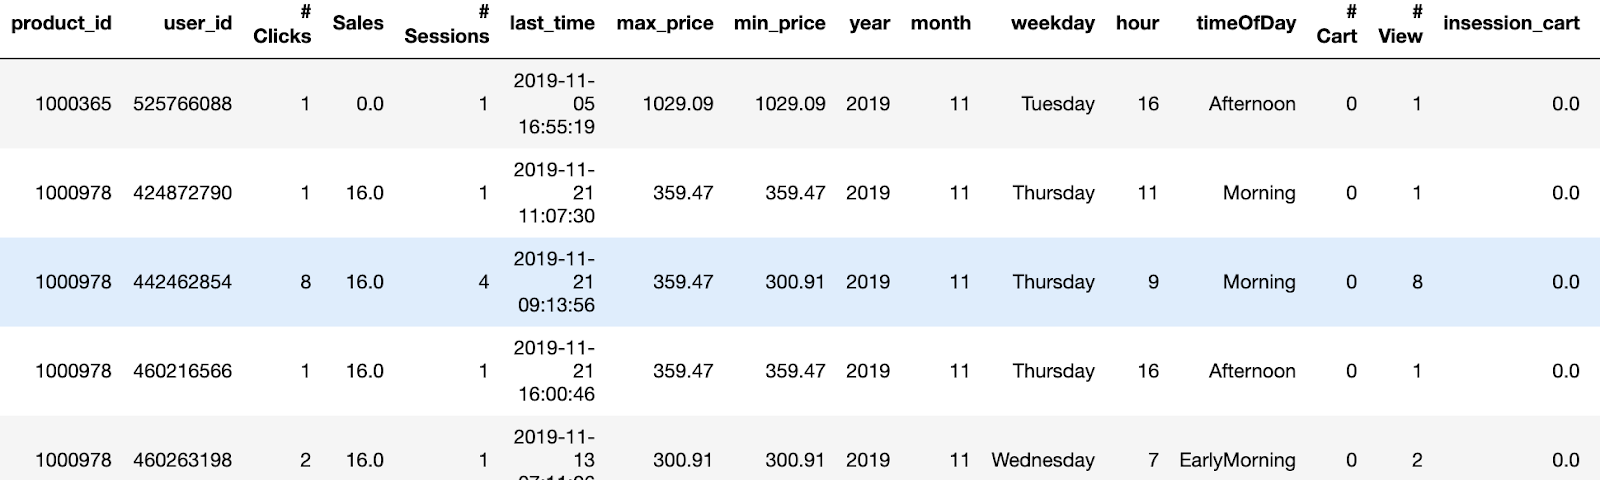

In [2]:
# The session-level data that is mined for this work is as follows:
from IPython.display import Image
Image(filename='../data/week4/image10.png')

## This week you are helping plan the launch of new products! You start with minimal product information and then identify what other information is helpful for the task!

## The minimal product level information available to you about the new products is their cost range and product category (cream, foundation, lipcolor, etc..).

## You have to figure out how to mine the past cosmetic sales data from last month, utilize relevant features and to make estimations as to which products will sell more (`Purchased?` = 1)

## Task 0: Getting to know the Data!

In [3]:
## Importing required Libraries
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sb
import warnings

warnings.filterwarnings('ignore')

In [4]:
# Load the data from previous months (past)
Past = pd.read_csv("../data/week4/Past_month_products.csv")
print(Past.shape)
Past.head()

(5000, 37)


,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.00,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.25,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.00,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.25,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.25,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0


In [5]:
# Next, load the data regarding products to be launched next month
Next = pd.read_csv("../data/week4/Next_month_products.csv")
print(Next.shape)
Next.head()


(30091, 5)


,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


### Only the `product_id`, `maxPrice`, `minPrice`, and `Category` columns are common to both the training and test data

# Task 1: Exploratory Data Analysis (EDA) and Data Preparation
## EDA: Doing our your due diligence. Find the following:
1. Percentage of Purchased events in train data: 
2. Percentage of Purchased events in test data:
3. Are there any overlaps in product ID between train and test data?

In [6]:
### START CODE HERE ###
y_train = Past['Purchased?'].values
percent_purchased_train = (y_train.sum()/len(Past))*100
print(f"Percentage of Purchased in Training data = {percent_purchased_train}")
y_test = Next['Purchased?'].values
percent_purchased_test = (y_test.sum()/len(Next))*100
print(f"Percentage of Purchased in Test data = {percent_purchased_test}")

# Verify that every product ID in the training data appears only once

print(f"Every product ID in the training data appears only once: {len(np.unique(Past['product_id'])) == Past.shape[0]}")
# Verify that every product ID in the test data appears only once
print(f"Every product ID in the test data appears only once: {len(np.unique(Next['product_id'])) == Next.shape[0]}")
# Determine whether any product IDs appear in both the training and test data
overlap = set(Past['product_id']).intersection(set(Next['product_id']))
print(f"These product IDs are present in both the training and test data: {overlap}")
### END CODE HERE ###

Percentage of Purchased in Training data = 34.38
Percentage of Purchased in Test data = 34.42557575354757
Every product ID in the training data appears only once: True
Every product ID in the test data appears only once: True
These product IDs are present in both the training and test data: set()


## Next, create `X_train`, `y_train`, `X_test`, and `y_test`. Remember the following: 
1. The `Purchased?` column is the target
2. `X_train` and `X_test` should contain the same features
3. `product_id` should NOT be one of those features. Can you see why?

In [7]:
### START CODE HERE ###
def return_train_test_data(df_old, df_new):
    # remove product_id
    # df_old = train
    # df_new = test
    X_train = df_old[['maxPrice', 'minPrice', 'Category']].values
    y_train = df_old[['Purchased?']].values
    X_test  = df_new[['maxPrice', 'minPrice', 'Category']].values
    y_test  = df_new[['Purchased?']].values
    return X_train, y_train, X_test, y_test
### END CODE HERE ###
    
X_train, y_train, X_test, y_test = return_train_test_data(Past, Next)    
print(X_train.shape, y_train.shape, X_test.shape)

(5000, 3) (5000, 1) (30091, 3)


# Task 2, Baselining: Build the best classifier using the Past month's data that will predict if the Next month's products will be Purchased or not?
## Consider using AutoML to estimate the best classifier. Which features would you use from the training data?

In [8]:
# Uncomment the following line if using Colab
!pip install tpot

     |████████████████████████████████| 87 kB 2.6 MB/s 
     |████████████████████████████████| 76 kB 7.9 MB/s 
     |████████████████████████████████| 109 kB 27.5 MB/s 
     |████████████████████████████████| 1.3 MB 16.7 MB/s 
Failed to build stopit
    Running setup.py install for stopit ... done
You should consider upgrading via the '/Users/christianwelling/Fourthbrain/Fourthbrain/fourthbrain_venv/bin/python3 -m pip install --upgrade pip' command.


In [9]:
# TPOT for classification
from tpot import TPOTClassifier
### START CODE HERE ###
# Instantiate and train a TPOT auto-ML classifier
# Set generations to 5, population_size to 40, and verbosity to 2 (so you can see each generation's performance)
# Use random_state as 42 to get the same results.
tpot = TPOTClassifier(generations=5, population_size=40, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
# Evaluate the classifier on the test data
# By default, the scoring function is accuracy

print(tpot.score(X_test, y_test))
### END CODE HERE ###
tpot.export('../data/week4/tpot_products_pipeline.py')


Generation 1 - Current best internal CV score: 0.8718

Generation 2 - Current best internal CV score: 0.8728

Generation 3 - Current best internal CV score: 0.8757999999999999

Generation 4 - Current best internal CV score: 0.8757999999999999

Generation 5 - Current best internal CV score: 0.8757999999999999

Best pipeline: RandomForestClassifier(GradientBoostingClassifier(SelectPercentile(input_matrix, percentile=12), learning_rate=0.01, max_depth=10, max_features=0.7000000000000001, min_samples_leaf=12, min_samples_split=14, n_estimators=100, subsample=0.8500000000000001), bootstrap=True, criterion=entropy, max_features=0.5, min_samples_leaf=5, min_samples_split=12, n_estimators=100)
0.8726197201821142


<!-- ## Modify the file `tpot_products_pipeline.py` to return the prediction labels for `X_test` and paste the function here or reload kernel to reload updated file -->

## Use the appropriate lines of `tpot_products_pipeline.py` (and modify the relevant names) to write a function which returns the predicted labels generated by the best classifier which TPOT found 

In [11]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier

from sklearn.pipeline import make_pipeline

def return_tpot_results(X_train, y_train, X_test):
    ### START CODE HERE ###
    #exported_pipeline = make_pipeline(GradientBoostingClassifier(RFE(X_train,
    #                                                   criterion='entropy',
    #                                                   max_features=0.1,
    #                                                   n_estimators=100,
    #                                                   step=0.15000000000000002),
    #                                               learning_rate=0.1,
    #                                               max_depth=9,
    #                                               max_features=0.35000000000000003,
    #                                               min_samples_leaf=19,
    #                                               min_samples_split=6,
    #                                               n_estimators=100,
    #                                               subsample=0.9500000000000001))
    
    exported_pipeline = make_pipeline(
    StackingEstimator(estimator=XGBClassifier(learning_rate=0.5, max_depth=3, min_child_weight=17, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)),
    BernoulliNB(alpha=10.0, fit_prior=False)
)

    exported_pipeline.fit(X_train, y_train)
    prediction = exported_pipeline.predict(X_test)
    ### END CODE HERE ### 
    return prediction

pred = return_tpot_results(X_train, y_train, X_test)


## Evaluate the results of the best classifier which TPOT found

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score

### START CODE HERE ###
# TPOT confusion matrix
cmtp = confusion_matrix(y_test, pred) 
acc  = accuracy(y_test, pred)
rec  = recall(y_test, pred)
prec = precision(y_test, pred)
f1   = f1_score(y_test, pred)
### END CODE HERE ###
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmtp)

Accuracy = 0.8725864876541158, Precision = 0.9550843911284698, Recall = 0.6609711362100589, F1-score = 0.7812642628936559
Confusion Matrix is:
[[19410   322]
 [ 3512  6847]]


# Task 3, Semi-supervised learning: Apply label spreading on the data and run performance analysis by cross validation.

Step 1: Combine `X_train` and `X_test`

Step 2: Combine `y_train` and pad `y_test` with -1 labels

Step 3: Run label spreading on complete data. Use knn spreading with `n_neighbors` varying as 2,3,5,7,9,11. What's the best neighborhood?


### Concatenate `X_train` and `X_test`

In [13]:
### START CODE HERE ###
X = np.concatenate((X_train, X_test))
### END CODE HERE ### 
print(X.shape[0])
print(y_train.shape)

35091
(5000, 1)


### Create an array shaped like a column of `X_test`, with each value equal to -1
### Make sure the array is a column vector

In [14]:
### START CODE HERE ###
y_hat = pred.reshape((-1,1))
### END CODE HERE ###

### Concatenate `y_train` and `y_hat`

In [15]:
### START CODE HERE ###
y = np.concatenate((y_train, y_hat))
### END CODE HERE ###

### Instantiate and fit LabelSpreading to do a basic hyper-parameter tuning to find the best `n_neighbors`. Use a KNN kernel and set `alpha` to 0.01.

In [16]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import recall_score
neighbors = [2, 3, 5, 7, 9, 11]
best_recall_score = 0.0
params = dict()

for neighbor in neighbors:
    ### START CODE HERE ###
    lp_model = LabelSpreading(kernel='knn', alpha=0.01)
    lp_model.fit(X, y)
    ### END CODE HERE ###
    y_pred = lp_model.transduction_[5000:]
    n_recall_score = recall_score(y_test, y_pred, average='weighted')
    if n_recall_score > best_recall_score:
        best_recall_score = n_recall_score
        params = lp_model.get_params()

print(f"best_recall: {best_recall_score:.4f}, best n_neighbors: {params['n_neighbors']}")

best_recall: 0.8726, best n_neighbors: 7


### Based on the best `n_neighbors`, fit the `LabelSpreading` on kernel `knn` and alpha `0.01`

In [17]:
from sklearn.semi_supervised import LabelSpreading
### START CODE HERE ###
lp_model = LabelSpreading(kernel='knn', alpha=0.01, n_neighbors=7)
lp_model.fit(X, y)
### END CODE HERE ###

LabelSpreading(alpha=0.01, kernel='knn')

### Extract the label predictions (transductions) for the test data

In [18]:
### START CODE HERE ###
semi_sup_preds = lp_model.transduction_[5000:] # ignore the training
### END CODE HERE

### Evaluate the test predictions against the true test labels

In [23]:
### START CODE HERE ###
cm   = confusion_matrix(y_test, semi_sup_preds) 
acc  = accuracy(y_test, semi_sup_preds)
#rec  = recall(y_test, semi_sup_preds, average='weighted')
rec  = recall(y_test, semi_sup_preds)
prec = precision(y_test, semi_sup_preds)
f1   = f1_score(y_test, semi_sup_preds)
### END CODE HERE ###
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)

Accuracy = 0.8725864876541158, Precision = 0.9550843911284698, Recall = 0.6609711362100589, F1-score = 0.7812642628936559
Confusion Matrix is:
[[19410   322]
 [ 3512  6847]]


## Observe Recall by running label spreading. Tabulate your results
----------------------------------------------------------------------------------------------------------------
| Method                   |   Recall            | F1-score           | Accuracy           |
| ------------------------ | ------------------  | ------------------ | ------------------ |
| AutoML                   | 0.6609711362100589  | 0.7812642628936559 | 0.8725864876541158 |
| Label Spread             | 0.6609711362100589* | 0.7812642628936559 | 0.8725864876541158 |

*Note: recall using a weighted average = 0.8725864876541158

# Task 4, System Design for Zero Shot Learning:
So far we have been looking at 3 product level features (min price, max price, Product Category) to classify if a particular product will get get purchased or not.
Now, let's say you have access to some more information regarding each Past sold cosmetic item and the Next cosmetic item. Design a System to enable accurate identification of an item that is more likely to be purchased.
Think through the following:
1. What additional data fields do you need per cosmetic in past and Next catalogue? How would you process these data fields?
2. You have access to picture images of each cosmetic. How will you use these images to extract relevant features for gauging interest in the new coemetics?
3. Design an end-to-end system workflow using the additional cosmetic data and cosmetic images to predict its purchasing polularity. 

__Use the sample solution in https://docs.google.com/presentation/d/1yhHFZO6vvTNBICr1dkZzbV0cdhaHsaSk/edit#slide=id.p1 as a guide__

### Make the required changes and put the picture corresponding to your version of the final System Diagram in the following cell.

### 1. What additional data would be useful?
Existing Features:
1. min price
2. max price
3. Product Category

Additional Features:
1. color
2. brand
3. packaging
4. size
5. weight
6. shape
7. product image (used to extract aforementioned features, possibly using zero-shot learning?)
8. additional sub-categories based off function, application area, application method, purpose, etc.

Considerations:
1. Can we incorporate user level data? How would this factor in? Users which have these common characteristics can be grouped together. Can these characteristics be feature inputs?
    a. Ignore user level data for now.
2. If we want incorporate zero-shot learning, we need to incorporate more sub-divisions and categories.
3. Can use PCA to group X user categories together into easier more predictable features for a new product

### 2. Have access to images of each cosmetic. How will you use these images to extract relevant features for gauging interest in the new cosmetics?

There are several approaches that come to mind.
1. Retrain a new model (CNN) using just the product image without any specified features. Add in the existing features (min price, max price, product category)
at the point where the model is fully connected. Use the purchase (y/n) as the label to train and predict. This approach allows the model to dictate the relevant features
from the image w/out having to dictate what they are.
2. Use a CNN trained using just the purchase label and product image. Have this prediction be used in conjunction with your existing model (co-training).
3. Use a zero-shot learning approach to extract relevant features from product images (label new/unknown product images), and then use those additional features to retrain the existing model w/
additional features. Can also apply PCA on these extracted features. 

### 3. Design an end-to-end system workflow using the additional cosmetic data and cosmetic images to predict its purchasing polularity. 

Considerations:

1. Need to set up schedule for retraining as there will drift e.g. temporal and seasonal changes affect who purchases what. If trained during christmas, there will be bias.
2. Deploy with some API on both ends
3. What zero-shot learning builds is not robust in our case. 
    a. For example, introduce a little noise, and the labels will not be robust (will incorrectly label).
    b. Thus, need to constantly monitor any zero-shot model and be thinking about them.
    c. Zero-shot learner can have good response on one task, but shit on another task.

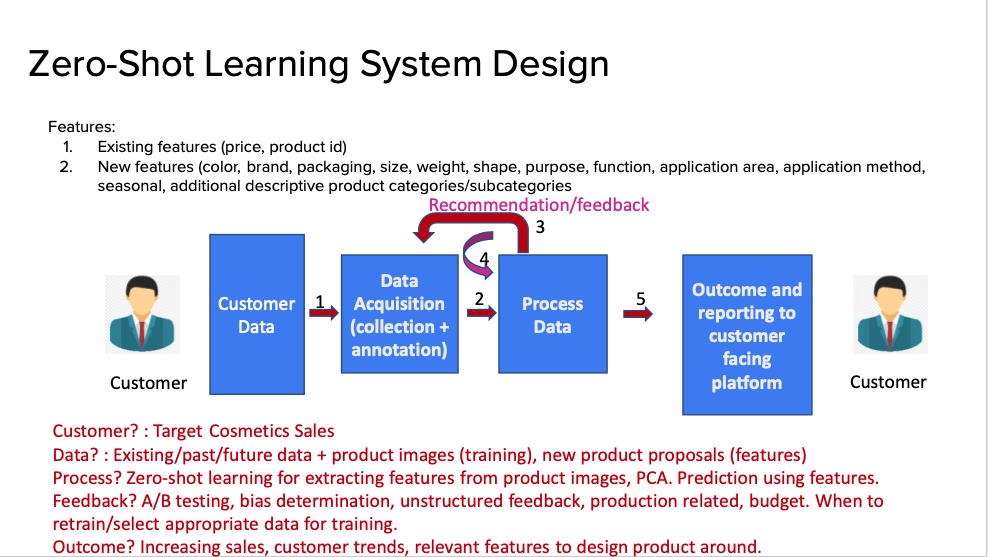

In [19]:
Image(filename='../data/week4/Target_Cosmetics_System_Design.png')